In [32]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader

from datasets import ImageDataset
from models import Generator, Discriminator


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)


cuda:0
1.9.0+cu111


In [2]:
DATASET_DIR = Path("./datasets/17flowers")
RESULTS_DIR = Path("./results/17flowers")
CHECKPOINTS_DIR = Path("./checkpoints/17flowers")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 512
IMG_CHANNELS = 3
BATCH_SIZE = 4


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = ImageDataset(root=DATASET_DIR, transform=transform, unaligned=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)


In [13]:
netG_A2B = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
netG_B2A = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
netD_A = Discriminator(in_channels=IMG_CHANNELS).to(device)
netD_B = Discriminator(in_channels=IMG_CHANNELS).to(device)

netG_A2B.load_state_dict(torch.load(CHECKPOINTS_DIR / "netG_A2B_final.pth"))
netG_B2A.load_state_dict(torch.load(CHECKPOINTS_DIR / "netG_B2A_final.pth"))
netD_A.load_state_dict(torch.load(CHECKPOINTS_DIR / "netD_A_final.pth"))
netD_B.load_state_dict(torch.load(CHECKPOINTS_DIR / "netD_B_final.pth"))

print("Successfully loaded models!")


<All keys matched successfully>

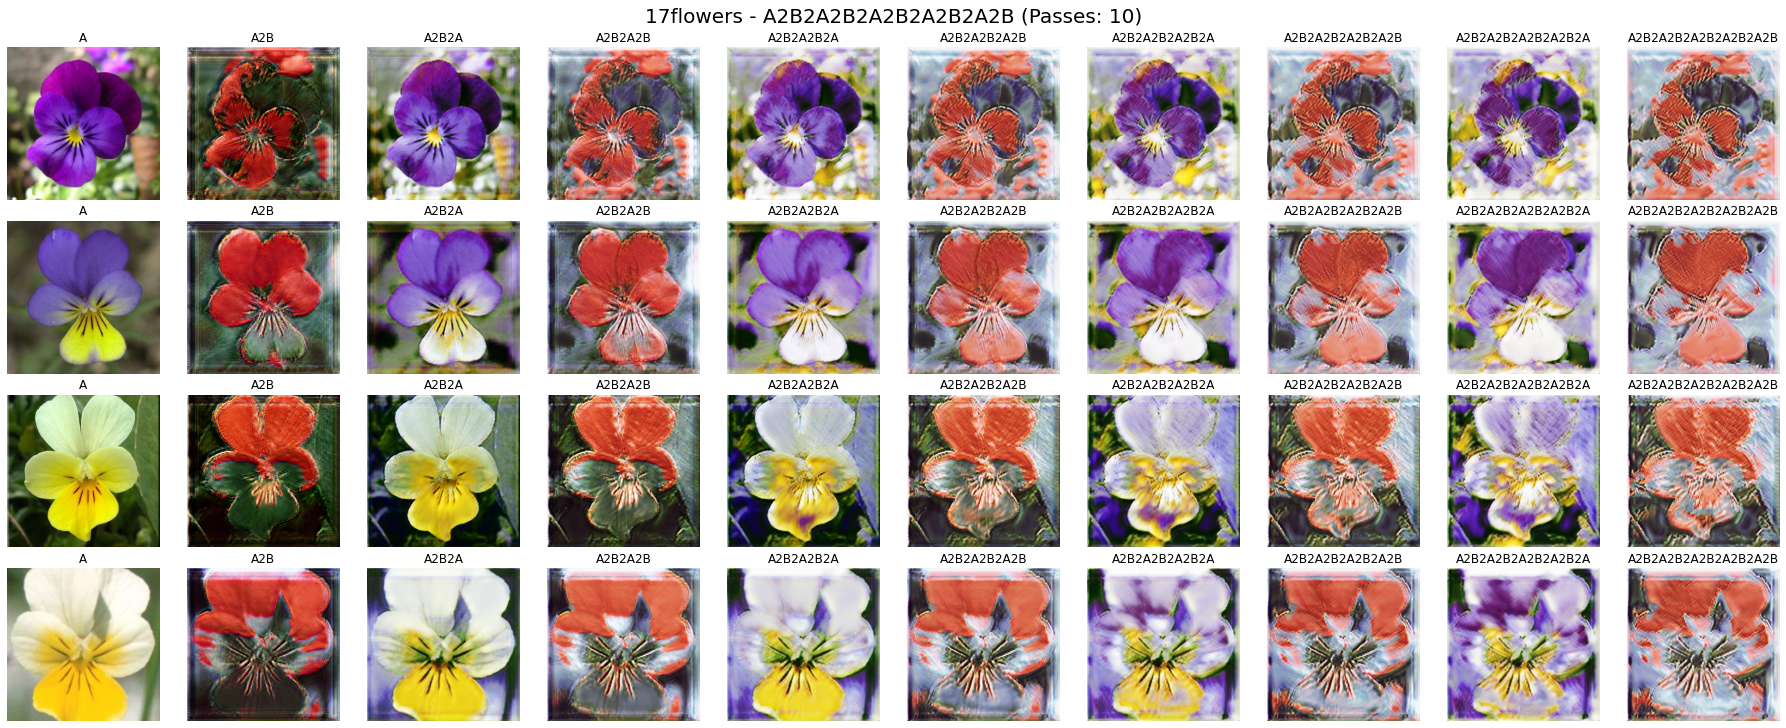

In [47]:
def make_fadein_gif(images, transitions=4, save_path=RESULTS_DIR / "recursive" / "fadein.gif"):
    frames = []
    for i in range(len(images) - 1):
        img1 = (images[i] * 255 / images[i].max()).astype('uint8')
        img2 = (images[i+1] * 255 / images[i+1].max()).astype('uint8')

        for i in range(0, transitions):
            fadein = i / transitions
            img = cv2.addWeighted(img1, 1-fadein, img2, fadein, 0)
            img = Image.fromarray(img)
            frames.append(img)

    frames.append(Image.fromarray(img2))
    frames[0].save(save_path, format='GIF', append_images=frames[1:], save_all=True, duration=500/transitions, loop=0)


@torch.no_grad()
def visualize_progression_A(sample_batch, passes=8):
    assert passes > 1 and passes < 15, "passes must be between 2 and 15"

    fig, axes = plt.subplots(BATCH_SIZE, passes, figsize=(passes*2.5, BATCH_SIZE*2.5), constrained_layout=True)
    [ax.set_axis_off() for ax in axes.ravel()]
    axes = list(map(list, zip(*axes)))
    generated_imgs = [sample_batch[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()]

    title = "A"
    for j, axj in enumerate(axes[0]):
        axj.imshow(sample_batch[j].cpu().permute(1, 2, 0).clamp(0, 1))
        axj.set_title(f"{title}")

    for i in range(1, passes):
        if i % 2:
            title += "2B"
            sample_batch = netG_A2B(sample_batch).detach()
            for j, axj in enumerate(axes[i]):
                axj.imshow(sample_batch[j].cpu().permute(1, 2, 0).clamp(0, 1))
                axj.set_title(f"{title}")

        else:
            title += "2A"
            sample_batch = netG_B2A(sample_batch).detach()
            for j, axj in enumerate(axes[i]):
                axj.imshow(sample_batch[j].cpu().permute(1, 2, 0).clamp(0, 1))
                axj.set_title(f"{title}")

        generated_imgs.append(sample_batch.cpu().permute(1, 2, 0).clamp(0, 1).numpy())

    fig.suptitle(f"17flowers - {title} (Passes: {passes})", fontsize=20)
    fig.savefig(RESULTS_DIR / "recursive" / f"passes_{passes}.jpg", facecolor="w", dpi=300)

    make_fadein_gif(generated_imgs, save_path=RESULTS_DIR / "recursive" / f"passes_{passes}.gif")


sample_batch = next(iter(dataloader))
visualize_progression_A(sample_batch['A'].to(device), passes=10)
